<a href="https://colab.research.google.com/github/Morax19/ML_UCV/blob/main/Tarea2/Tarea2_ML_DanielHernandez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



TAREA 2: APRENDIZAJE SUPERVISADO<br>
Aprendizaje Automático, Escuela de Computación, Facultad de Ciencias - UCV
<br>
<br>
#Parte 1: Reconocimiento de Dígitos
<br>
<br>
Autor: Daniel Hernández<br>
Fecha: 14 de Febrero 2025



## Overview
Breve introducción al notebook

---

### Setup enviroment

Librerías necesarias a lo largo del notebook:

In [2]:
SEED = 27795163

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from keras.datasets import mnist
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV

### Pre-procesamiento


El conjunto de datos con el que vamos a trabajar a lo largo de este notebook es [MNIST](https://docs.ultralytics.com/es/datasets/classify/mnist/). *Definición de que es MNIST.*

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Se formatean y se separan los datos de la siguiente forma:


*   X: Contiene los valores de los píxeles de las imágenes
*   y: Contiene las etiquetas asociadas a las imágenes



In [4]:
#Valores de los pixeles en un arreglo NumPy
X = np.concatenate((X_train, X_test), axis = 0)

#Etiquetas que identifican los objetivos de las imágenes
y = np.concatenate((y_train, y_test), axis = 0)

Luego se separan los datos en grupos de entrenamiento y prueba, para esto se hizo uso de una relación 70 - 30 respectivamente. Posteriormente se transforma la representación de los datos en X en imágenes de dimensión 28x28 píxeles y se normalizan sus valores.

In [5]:
#Se separan los datos de entrenamiento y prueba (70 entrenamiento - 30 prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = SEED)

#Se formatean los valores de X
X_train = X_train.reshape(X_train.shape[0], 28 * 28)
X_test = X_test.reshape(X_test.shape[0], 28 * 28)

#Se normalizan los valores de las imágenes
X_train = X_train / 255.0
X_test = X_test / 255.0

#Finalmente, podemos tener una vista previa de los datos con los que vamos a trabajar
print(f"Cantidad de imágenes para entrenamiento: {X_train.shape[0]}")
print(f"Cantidad de imágenes de prueba: {X_test.shape[0]}")

Cantidad de imágenes para entrenamiento: 49000
Cantidad de imágenes de prueba: 21000


##   Regresión Logística



Breve explicacion de que es regresion logistica y porque se utiliza para esta tarea

### Sección 1, import del modelo.

Se importa el modelo desde SciKitLearn

In [6]:
from sklearn.linear_model import LogisticRegression

### Sección 2, métricas del modelo

El modelo utilizado en esta sección será [Regresión Logística](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [7]:
#Se usa el modelo de regresión logística, agregando una penalidad Ridge de 0.5
modelLR = LogisticRegression(max_iter = 1000, penalty = 'l2', C = 0.5, solver = 'lbfgs')

Para tener una idea de como se comporta el modelo frente a datos desconocidos, haremos uso de validación cruzada y se almacenarán las siguientes métricas:
*   Accuracy: Explicacion de que es
*   F1 Score: Same as above


In [8]:
#Métricas a utilizar
scores = ['accuracy', 'f1_weighted']

In [7]:
#Los valores obtenidos al medir la precisión del modelo
cv_scores_LR = cross_validate(modelLR, X_train, y_train, cv = 5, scoring = scores)

print(f"Resultados obtenidos:\n")
print(f"Accuracy por fold (prueba): {cv_scores_LR['test_accuracy']} \nValor promedio en porcentaje: {cv_scores_LR['test_accuracy'].mean()*100:.2f}%\n")
print(f"F1 Score por fold (prueba): {cv_scores_LR['test_f1_weighted']} \nValor promedio en porcentaje: {cv_scores_LR['test_f1_weighted'].mean()*100:.2f}%\n")

Resultados obtenidos:

Accuracy por fold: [0.91673469 0.92142857 0.92204082 0.92061224 0.91785714] 
Valor promedio en porcentaje: 91.97%

F1 Score por fold: [0.91660095 0.92135014 0.92191544 0.92049449 0.91758574] 
Valor promedio en porcentaje: 91.96%



### Sección 4, entrenamiento y prueba del modelo

Finalmente, se procede a entrenar el modelo usando el conjunto de datos definido anteriormente para esta tarea.

In [9]:
#Do not disturb... Machine is Learning
modelLR.fit(X_train, y_train)

LogisticRegression(C=0.5, max_iter=1000)

Una vez entrenado, se realizan algunas predicciones utilizando el conjunto de datos definido para prueba.

In [10]:
#Primeras pruebas con el modelo
y_pred_LR = modelLR.predict(X_test)

#Se calcula la precisión obtenida
acc_pred_LR = accuracy_score(y_test, y_pred_LR)

#Se calcula la matriz de confusión asociada
conf_matrix_LR = confusion_matrix(y_test, y_pred_LR)

print(f"Predicciones: {y_pred_LR}\nValores Reales: {y_test}\n")
print(f"Accuracy: {acc_pred_LR * 100:.2f}%")

Predicciones: [0 9 1 ... 7 4 7]
Valores Reales: [0 9 1 ... 7 4 7]

Accuracy: 92.12%


Acá se pueden visualizar de mejor manera los resultados obtenidos por el modelo.

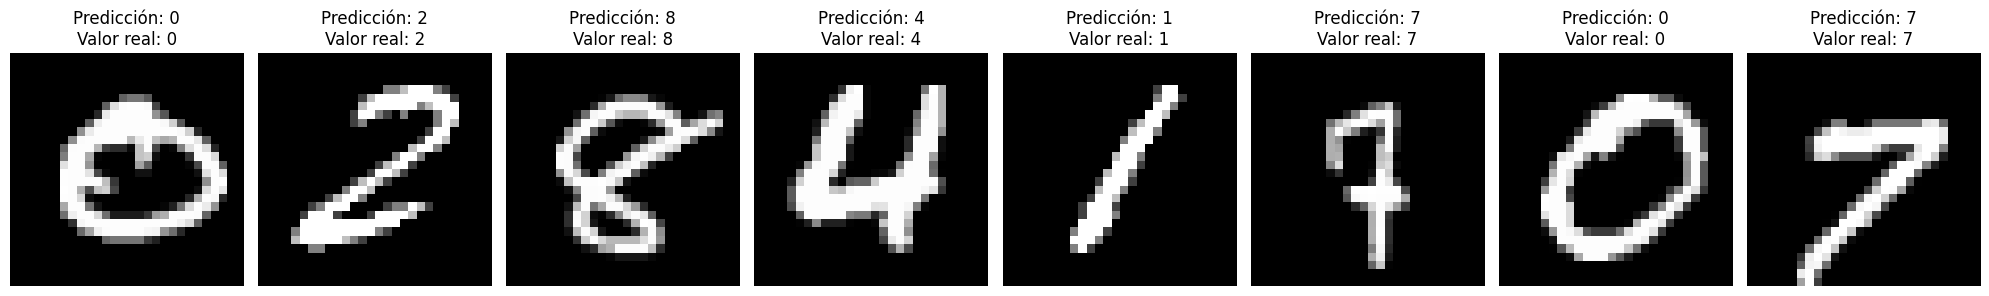

In [21]:
samples = 8
samples_index = np.random.choice(len(X_test), samples, replace = False)

plt.figure(figsize=(20, 10))

for i, index in enumerate(samples_index):
    plt.subplot(1, samples, i + 1)
    plt.imshow(X_test[index].reshape(28, 28), cmap = 'gray')
    plt.title(f"Predicción: {y_pred_LR[index]}\nValor real: {y_test[index]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

Para finalizar, se muestra la matriz de confusión obtenida es la siguiente:

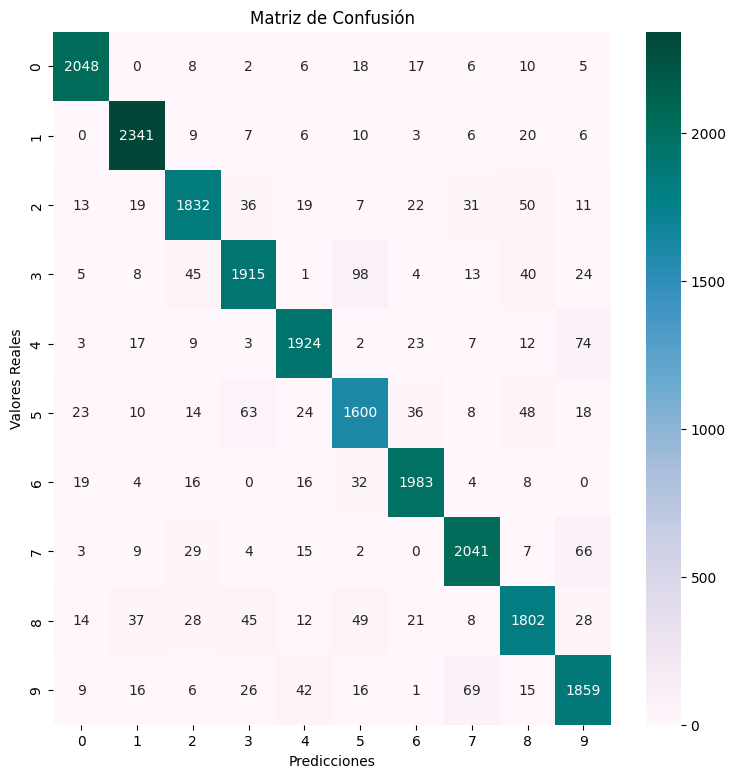

In [22]:
plt.figure(figsize = (9, 9))

sns.heatmap(
    conf_matrix_LR, annot = True,
    fmt = 'd',
    cmap = 'PuBuGn',
    xticklabels = range(10),
    yticklabels = range(10)
    )

plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.show()

## K-Vecinos

### Seccion 1

Explicacion e import de las librerias necesarias para el modelo

In [13]:
from sklearn.neighbors import KNeighborsClassifier

### Seccion 2, seleccion de hiperparametros

Explicacion de los hiperparametros de KNN y el como se obtienen sus valores optimos
* K:
* Pesos:
* Distancia:

In [15]:
#El siguiente fragmento de código tiene como finalidad encontrar los valores optimales para los hiperparámetros ya mencionados
#Esta tarea toma mucho tiempo de ejecución por lo cual se decidió comentarla

#param_grid = {
#    'n_neighbors': range(2, 10),
#    'weights': ['uniform', 'distance'],
#    'metric': ['euclidean', 'manhattan', 'minkowski']
#    }

#Se usa GridSearchCV para calcular en k optimo
#grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv = 5, scoring = scores, refit='f1_weighted')

#grid_search.fit(X_train, y_train)

Después de haber realizado las pruebas correspondientes, se obtuvieron los siguientes valores para los hiperparámetros:

* K = 3
* weights = 'distance'
* metric = 'euclidean'

In [14]:
param_grid = {
    'n_neighbors': [3],
    'weights': ['distance'],
    'metric': ['euclidean']
    }

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv = 5, scoring = scores, refit='f1_weighted')

In [15]:
#Shhhh... Machine is Learning (again)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean'], 'n_neighbors': [3],
                         'weights': ['distance']},
             refit='f1_weighted', scoring=['accuracy', 'f1_weighted'])

In [16]:
print(f"Mejores hiperparámetros encontrados:\n")
print(f"Best K: {grid_search.best_params_['n_neighbors']}")
print(f"Best weights: {grid_search.best_params_['weights']}")
print(f"Best metric: {grid_search.best_params_['metric']}")
print(f"F1 Score (weighted): {grid_search.cv_results_['mean_test_f1_weighted'].mean() * 100:.2f}%")
print(f"Accuracy: {grid_search.cv_results_['mean_test_accuracy'].mean() * 100:.2f}%")

Mejores hiperparámetros encontrados:

Best K: 3
Best weights: distance
Best metric: euclidean
F1 Score (weighted): 96.99%
Accuracy: 96.99%


### Sección 3, pruebas con el modelo

In [17]:
modelKNN = grid_search.best_estimator_

Resultados obtenidos:

In [18]:
#Primeras predicciones del modelo:
y_pred_KNN = modelKNN.predict(X_test)

#Se calcula la precisión obtenida
acc_pred_KNN = modelKNN.score(X_test, y_test)

#Se calcula la matriz de confusión asociada
conf_matrix_KNN = confusion_matrix(y_test, y_pred_KNN)

print(f"Predicciones: {y_pred_KNN}\nValores Reales: {y_test}\n")
print(f"Accuracy: {acc_pred_KNN * 100:.2f}%")

Predicciones: [0 9 1 ... 7 4 7]
Valores Reales: [0 9 1 ... 7 4 7]

Accuracy: 97.27%


Visualizaciones

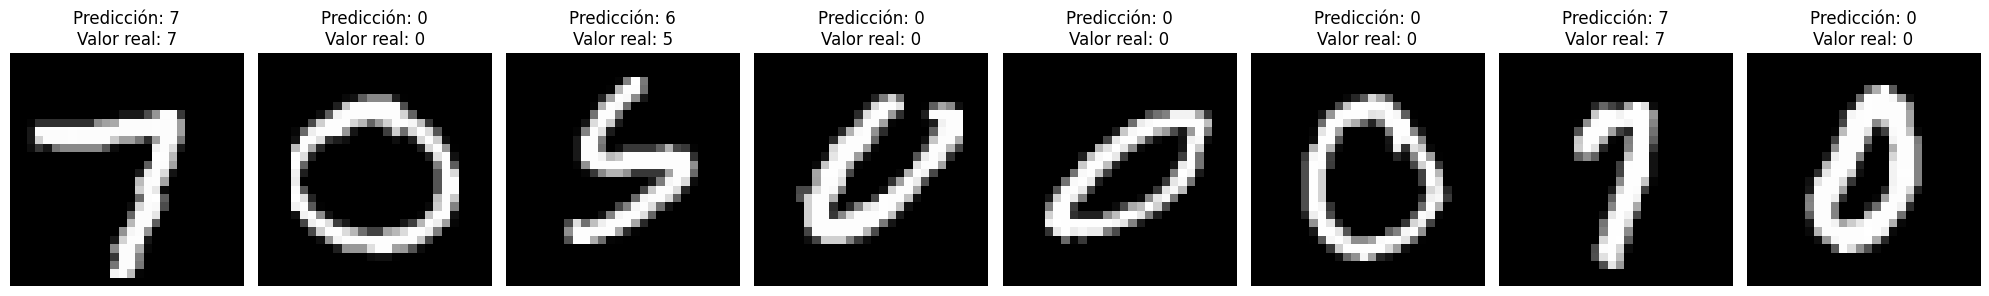

In [19]:
samples = 8
samples_index = np.random.choice(len(X_test), samples, replace = False)

plt.figure(figsize=(20, 10))

for i, index in enumerate(samples_index):
    plt.subplot(1, samples, i + 1)
    plt.imshow(X_test[index].reshape(28, 28), cmap = 'gray')
    plt.title(f"Predicción: {y_pred_KNN[index]}\nValor real: {y_test[index]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

Matriz de confusion:

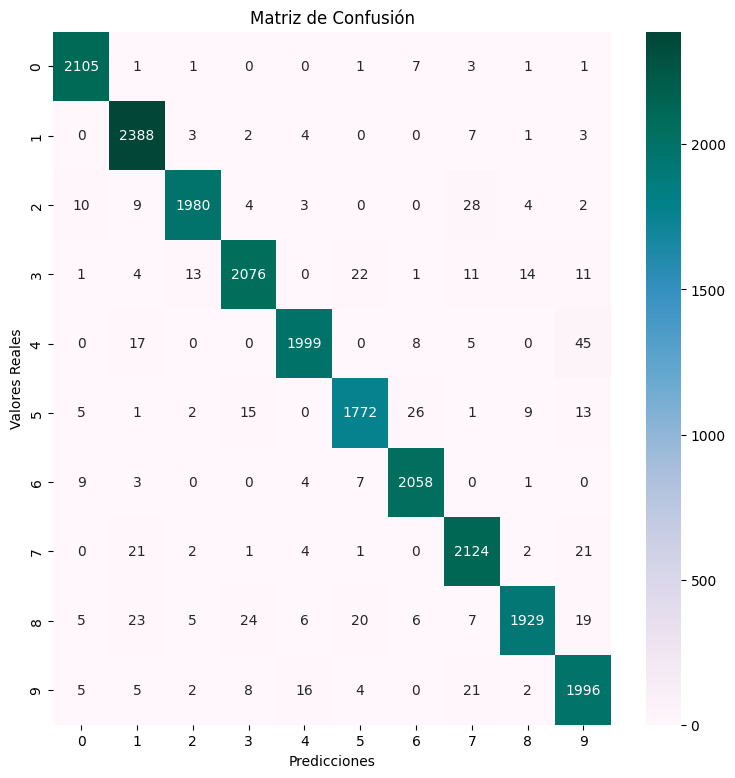

In [23]:
plt.figure(figsize = (9, 9))

sns.heatmap(
    conf_matrix_KNN, annot = True,
    fmt = 'd',
    cmap = 'PuBuGn',
    xticklabels = range(10),
    yticklabels = range(10)
    )

plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.show()

## SVM

### Seccion 1